# Drinking Water Quality Prediction
Project 1 for the *Explainable Automated Machine Learning* (LTAT.02.023) course

**Authors**: <br>
Dmitri Rozgonjuk <br>
Lisanna Lehes <br>
Marilin Moor <br>

### Table of Contents

* [Background](#background): A brief overview of project goals <br>
* [Setup](#setup): Installing/importing libraries and configuring the notebook settings <br>
* [Data Exploration](#data_explore): Data import and initial description <br>
* [Data Cleaning and Testing Alternatives](#data_clean): Choosing the best input data  <br>
* [Baseline Model Selection](#baseline_model) <br>
    * [An Overview of Classifiers ](#classifiers): A brief description of selected algorithms <br>
    * [Classifiers and Search Spaces](#search_space): Manually defined search spaces <br>
    * [Baseline Performance of Classifiers](#bl_performance): Accuracy and runtime for each classifier
* [Hyperparameter Optimization (HPO)](#hpo): HPO pipeline creation iterations <br>
    * [Accuracy-Runtime Comparison for Classifiers](#hpo_acc_runtime):  Accuracy and runtime for each HPO-engineered classifier
    * [Hyperparameter-Accuracy Links Across All Trials](#hpo_params_trials): Can we spot performance improvements in different hyperparameters?
* [Significance Testing](#sig_test): Do the best baseline and HPO-engineered model differ from each other? <br>
* [Model Accuracy Validation via a Kaggle Competition](#kaggle): How do the models fare off with predicting new values?
* [Summary and Conclusions](#summary): What did we achieve and what did we learn?

## Background <a class="anchor" id="background"></a>
In the present project, the main aim is to automate drinking water quality predictions. To that end, we first use the baseline predictions of 13 different classifiers. Then, we use Hyperparameter Optimization (HPO) to aim to improve the predictions of the baseline models via a mostly automated pipeline.

<font color = 'red'> [SIIA PIPELINE FLOWCHART] also, ma teg ei tea, kas peaks siia juurde kirjutama. </font>



## Setup  <a class="anchor" id="setup"></a>

In [1]:
# Install packages
#!pip install hyperopt
#!pip install git+https://github.com/hyperopt/hyperopt.git
#!pip install git+https://github.com/hyperopt/hyperopt-sklearn
#!pip install xgboost
#!pip install threadpoolctl --upgrade
#!pip install missingpy

In [2]:
# Libraries
## Data frames and arrays
import pandas as pd
import numpy as np

## Model training and evaluation
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

## Classifiers
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.base import clone # for cloning the baseline estimator

## Hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import hyperopt.pyll.stochastic

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Differences testing
from scipy.stats import ttest_rel # dependent-samples t-test

## Misc
import time
import warnings
warnings.filterwarnings("ignore")

# avoid sklearn.neighbors import error 
# https://stackoverflow.com/questions/60145652/no-module-named-sklearn-neighbors-base
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

# random forest imputer
from missingpy import MissForest

## Data Exploration  <a class="anchor" id="data_explore"></a>

In [3]:
train_df = pd.read_csv("data/train.csv")
train_df.shape # 440 rows

(440, 58)

In [4]:
train_df.columns # 58 features altogether

Index(['station_id', 'Aluminium_2019', 'Aluminium_2020', 'Ammonium_2019',
       'Ammonium_2020', 'Boron_2019', 'Boron_2020', 'Chloride_2019',
       'Chloride_2020', 'Coli-like-bacteria-Colilert_2019',
       'Coli-like-bacteria-Colilert_2020', 'Coli-like-bacteria_2019',
       'Coli-like-bacteria_2020', 'Colony-count-at-22-C_2019',
       'Colony-count-at-22-C_2020', 'Color-Pt-Co-unit_2019',
       'Color-Pt-Co-unit_2020', 'Color-Pt/Co-scale_2019',
       'Color-Pt/Co-scale_2020', 'Electrical-conductivity_2019',
       'Electrical-conductivity_2020', 'Enterococci_2019', 'Enterococci_2020',
       'Escherichia-coli-Colilert_2019', 'Escherichia-coli-Colilert_2020',
       'Escherichia-coli_2019', 'Escherichia-coli_2020', 'Fluoride_2019',
       'Fluoride_2020', 'Iron_2019', 'Iron_2020', 'Manganese_2019',
       'Manganese_2020', 'Nitrate_2019', 'Nitrate_2020', 'Nitrite_2019',
       'Nitrite_2020', 'Odour-dilution-level_2019',
       'Odour-dilution-level_2020', 'Oxidability_2019', 'Ox

In [5]:
train_df.describe()

,station_id,Aluminium_2019,Aluminium_2020,Ammonium_2019,Ammonium_2020,Boron_2019,Boron_2020,Chloride_2019,Chloride_2020,Coli-like-bacteria-Colilert_2019,...,Taste-ball-units_2020,Taste-dilution-degree_2019,Taste-dilution-degree_2020,Turbidity-NTU_2019,Turbidity-NTU_2020,pH _2019,pH _2020,compliance_2019,compliance_2020,compliance_2021
count,440.000000,103.000000,94.000000,307.000000,290.000000,116.000000,108.000000,111.000000,114.000000,125.000000,...,103.000000,305.000000,306.000000,419.000000,426.000000,432.000000,438.000000,440.000000,440.000000,440.000000
mean,847.884091,16.932117,10.102528,0.139752,0.132352,0.321819,0.497083,68.046847,66.514912,20.708800,...,0.524272,1.596721,1.650327,1.404081,1.395329,7.586852,7.652922,0.197727,0.200000,0.150000
std,482.227347,73.882649,12.298492,0.294113,0.236251,0.423732,0.939406,95.549023,84.631374,216.467309,...,0.639311,1.540460,1.429874,3.183978,2.982040,0.303888,0.315106,0.398739,0.400455,0.357478
min,165.000000,0.002000,0.002000,0.027000,0.020000,0.002000,0.009000,1.000000,0.700000,0.000000,...,0.000000,1.000000,1.000000,0.180000,0.140000,6.500000,6.600000,0.000000,0.000000,0.000000
25%,460.500000,5.000000,5.000000,0.050000,0.050000,0.100000,0.100000,4.900000,10.125000,0.000000,...,0.000000,1.000000,1.000000,0.960000,0.850000,7.400000,7.400000,0.000000,0.000000,0.000000
50%,741.000000,10.000000,5.000000,0.050000,0.050000,0.178500,0.252500,21.500000,31.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,7.600000,7.600000,0.000000,0.000000,0.000000
75%,1174.000000,10.000000,10.000000,0.140000,0.140000,0.403500,0.598500,99.500000,98.475000,0.000000,...,1.000000,2.000000,2.000000,1.000000,1.000000,7.800000,7.900000,0.000000,0.000000,0.000000
max,2311.000000,754.000000,76.900000,3.500000,3.300000,3.700000,7.700000,461.000000,468.000000,2419.600000,...,3.000000,16.000000,16.000000,50.000000,44.000000,8.640000,8.470000,1.000000,1.000000,1.000000


In [6]:
# sanity drop 
train_df = train_df.drop_duplicates()

Every row contains at least one NaN

In [7]:
len(train_df.isna()) / len(train_df)

1.0

The following plot describes the amount of NaNs per feature

<AxesSubplot:ylabel='feature'>

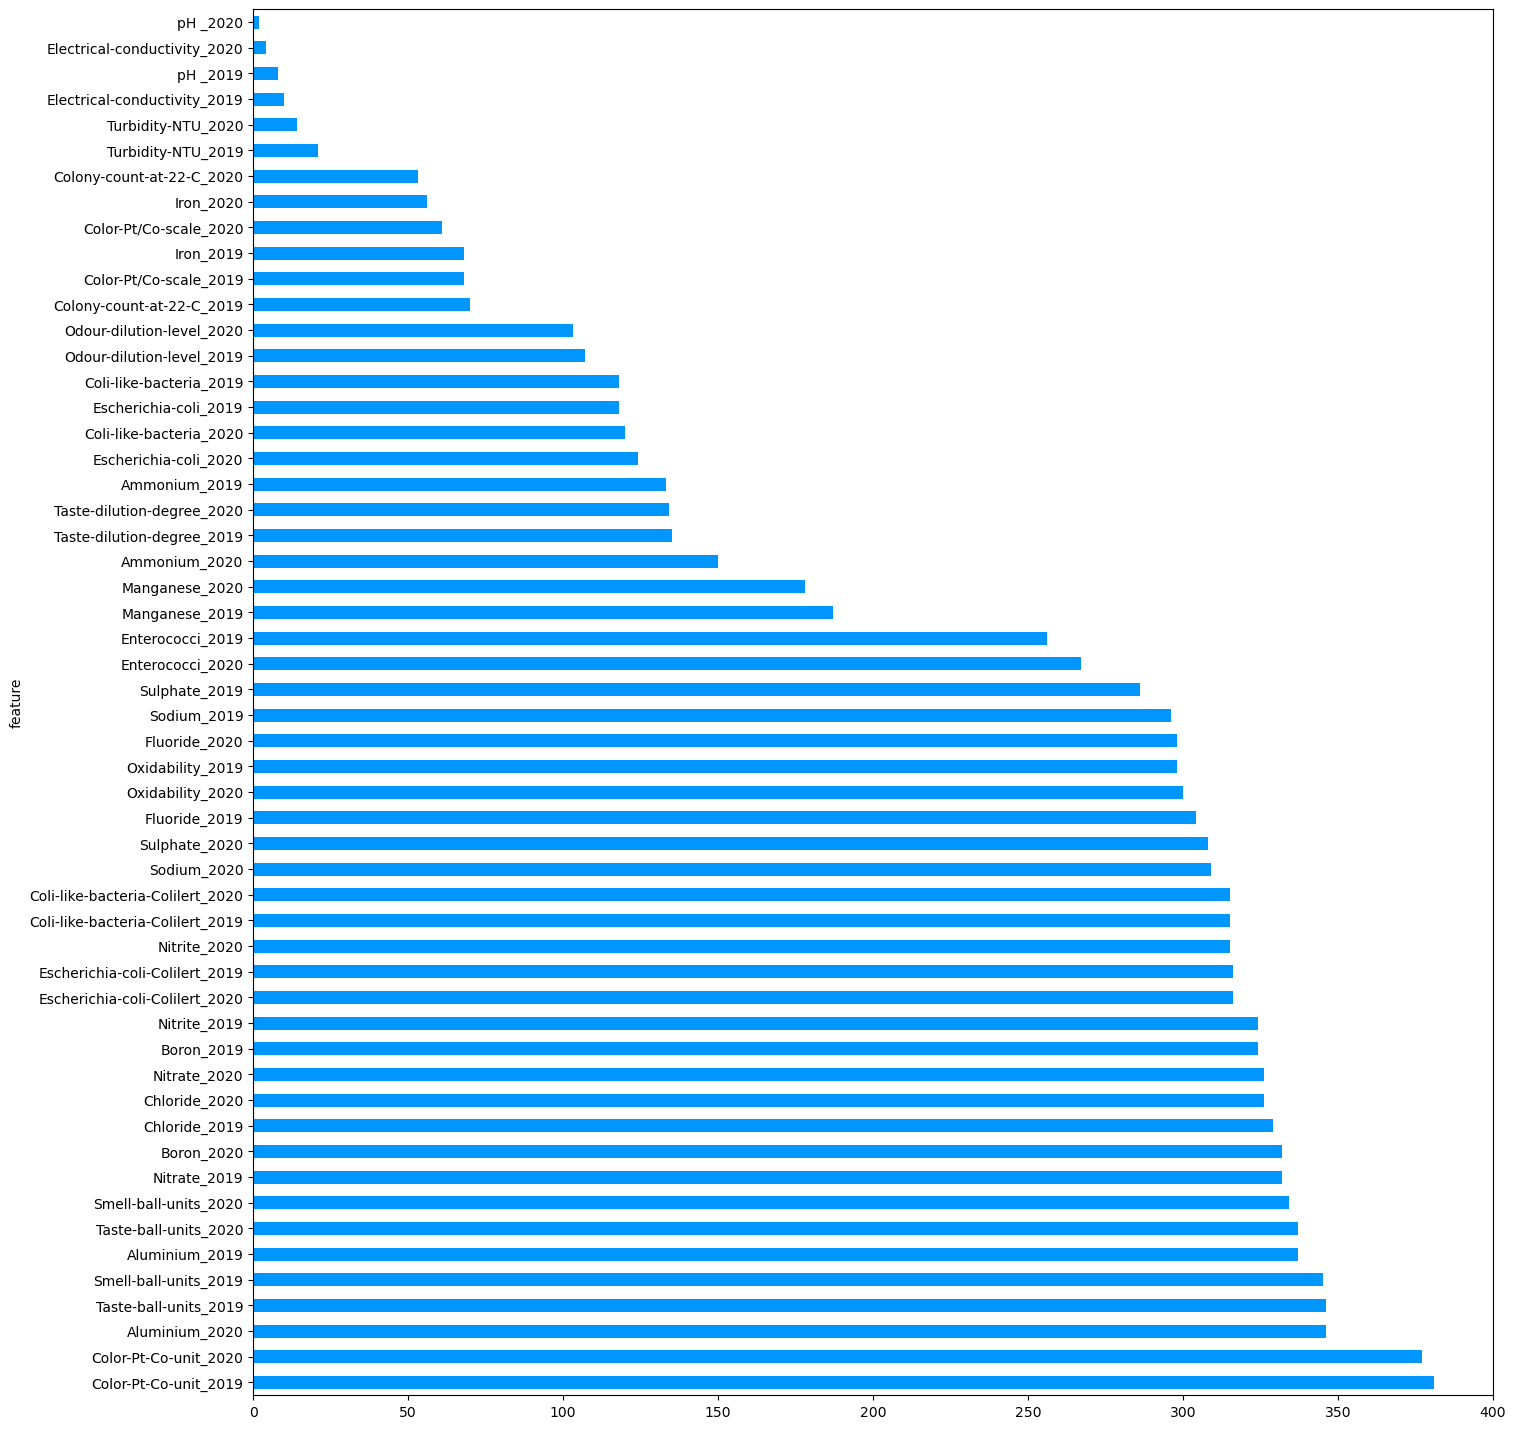

In [8]:
plot_width, plot_height = (16,18)
plt.rcParams['figure.figsize'] = (plot_width,plot_height)
train_df.isna().sum()[train_df.isna().sum()>0].sort_values(ascending = False).plot(xlabel = "feature", color = "#0096ff", ylabel = "amount of NaNs", kind='barh')

Dropping columns that had more than 50% of rows with NaN 

In [9]:
perc = 50.0
modified_df = train_df.dropna(axis=1, thresh=int(((100-perc)/100)* len(train_df) + 1))

In [10]:
print(f"Dropping NaNs would return only {len(modified_df.dropna())} rows → imputation definitely needed")

Dropping NaNs would return only 32 rows → imputation definitely needed


Exploring if there is some correlation between the station id and features - theory that station id-s closer to each other are closer location-wise which may lead to having similar features (better for interpolation purposes)

<AxesSubplot:>

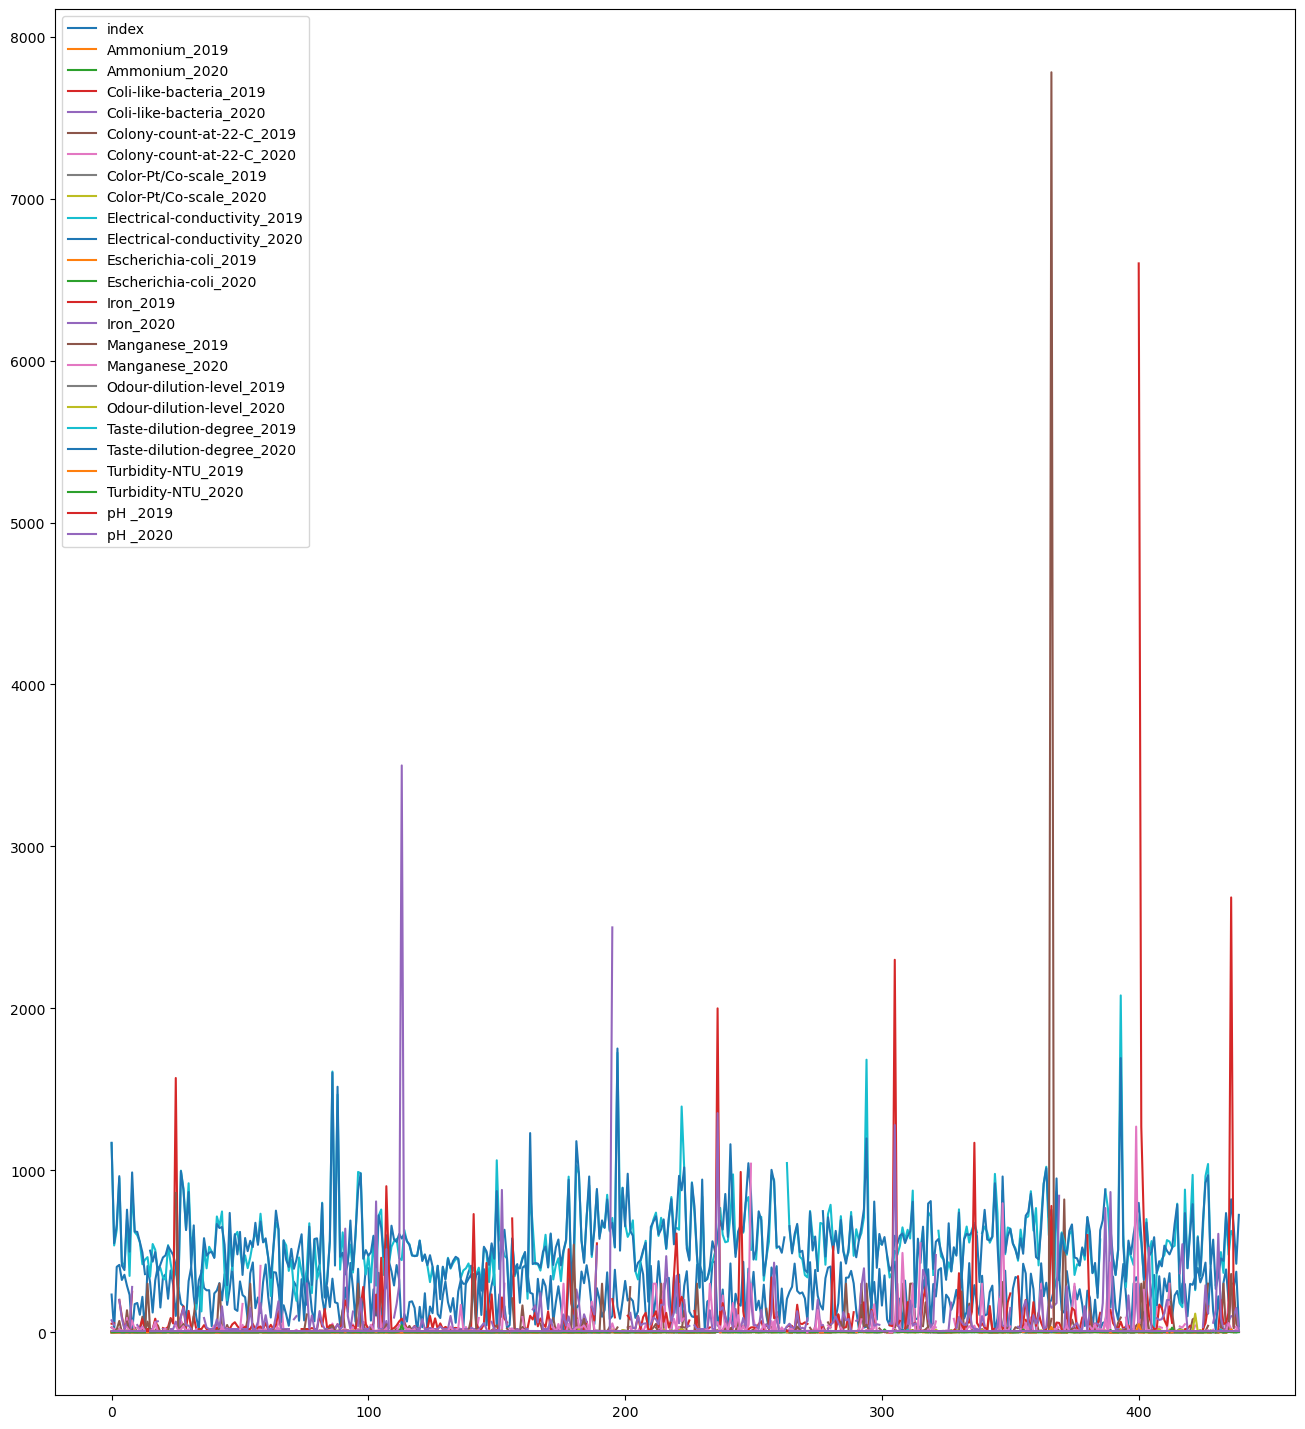

In [11]:
modified_df.sort_values(by = "station_id", inplace = True)
# very little effect - maybe more flatter areas
modified_df.iloc[:, 1:-3].reset_index().plot()

Feature value distribution

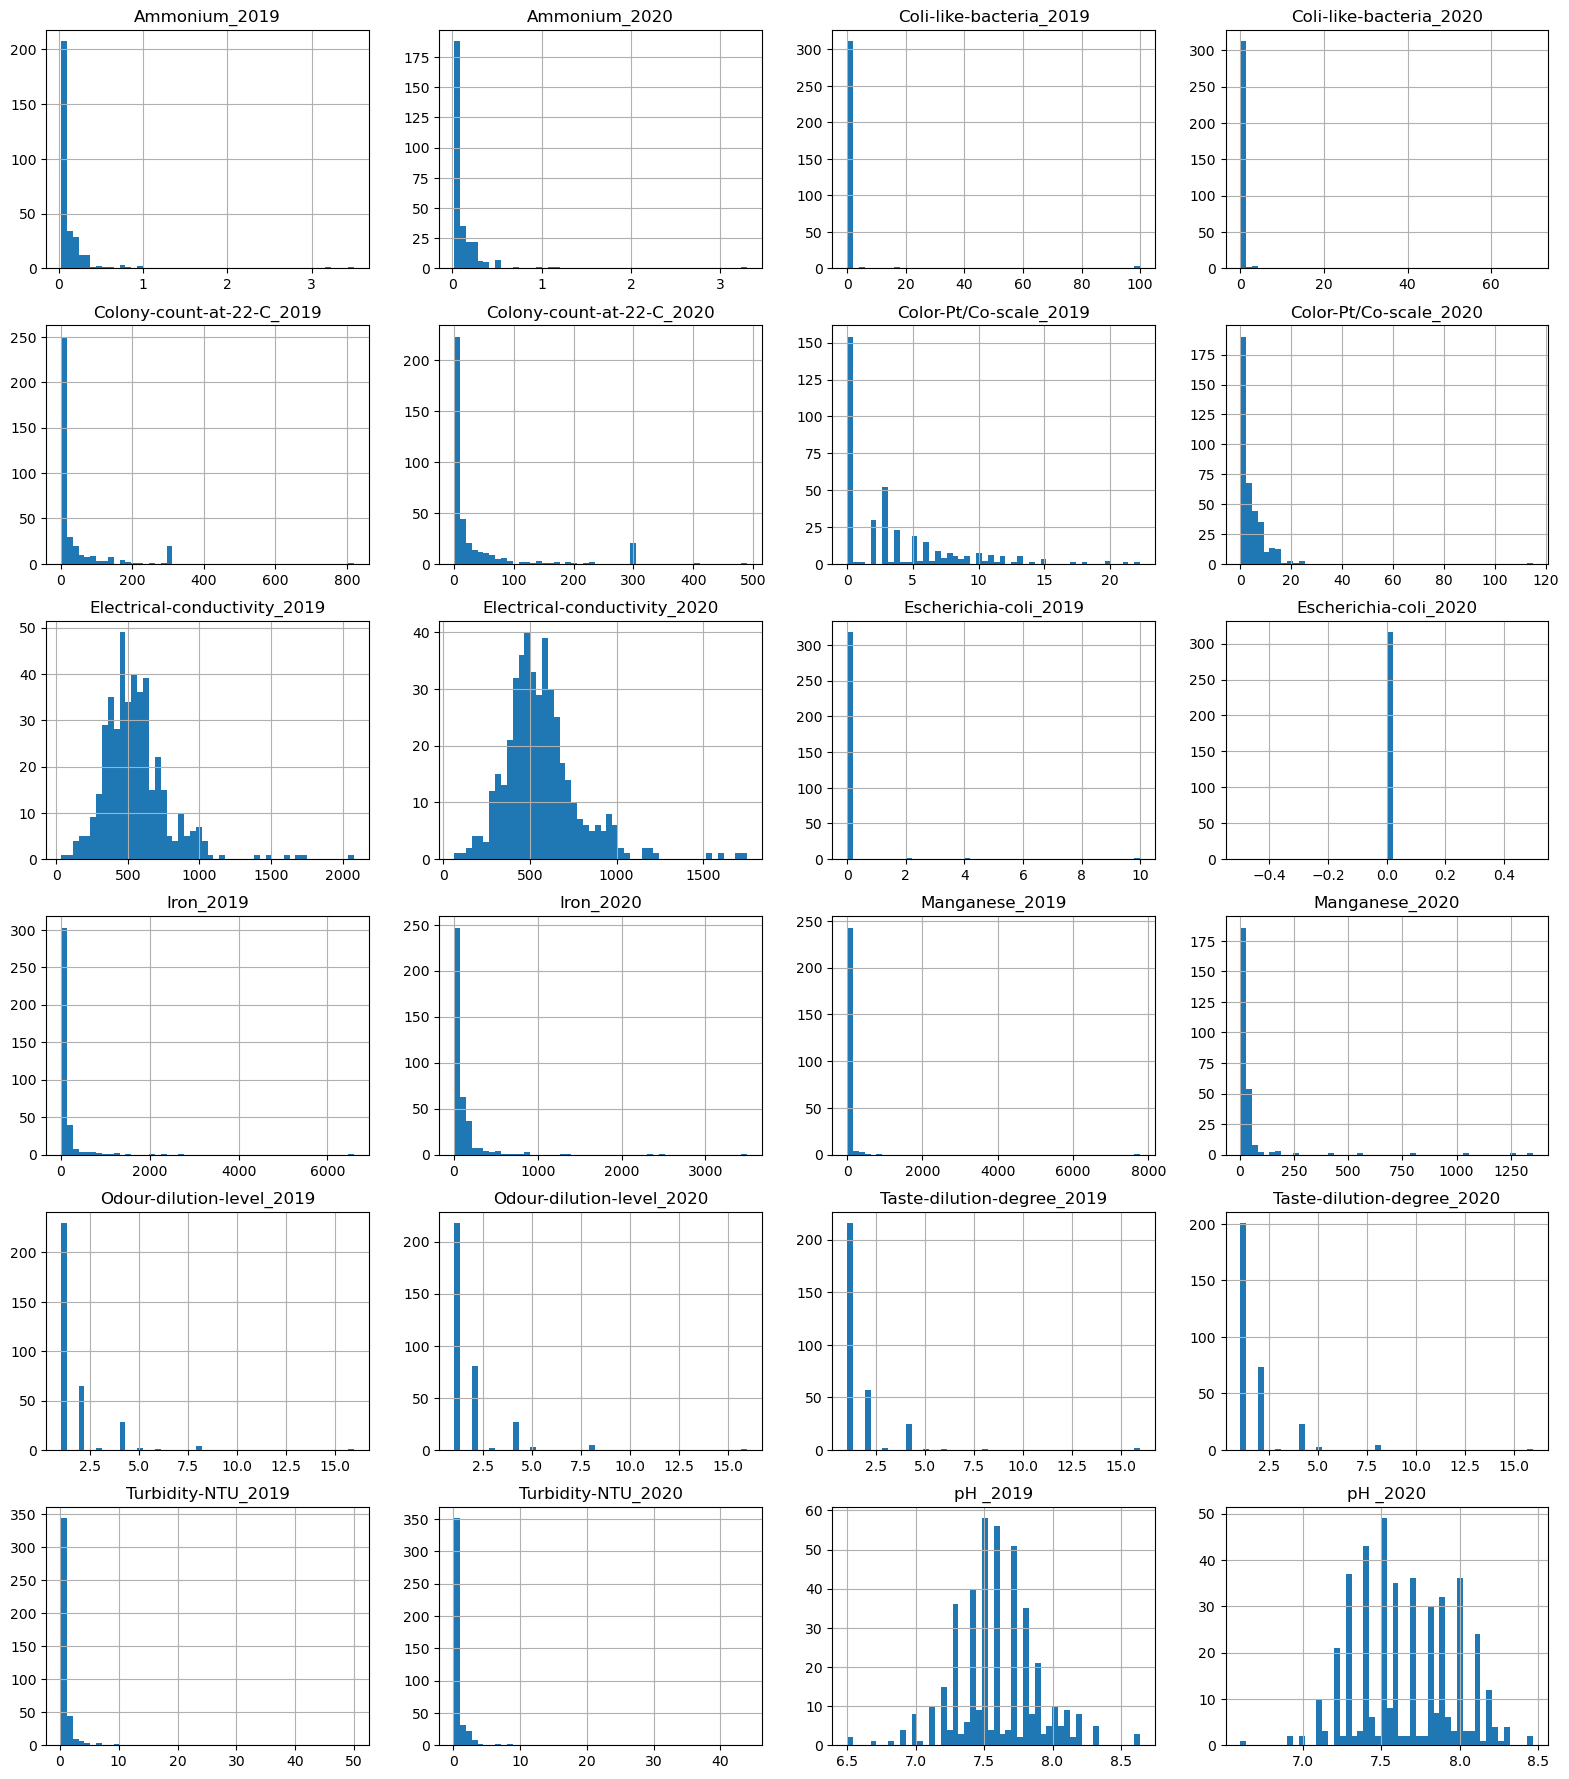

In [12]:
# checking out the distributions of features
rows, cols = 6, 4
fig, axes = plt.subplots(rows, cols)
fig.tight_layout(pad=2.0)
axe = axes.ravel()

for i, val in enumerate(modified_df.columns[1:-3]):
    
    axe[i].title.set_text(f"{val}")
    modified_df[f"{val}"].hist(bins = 50, ax = axe[i])

Most attributes follow exponential distributions, except for: 
* electrical conductivity which tends to have a negative binomial distribution
* pH has a relatively gaussian distribution <br>

Will not remove any extremes/seemingly outliers for the following reasons: 
* could be unique to specific station id-s 
* not an expert in water quality, maybe it is normal <br> 

Generally the features have similar distribution and value range despite the year → merging feature data of both years might not be a bad idea

In [13]:
# will fill the NaNs in E-coli 2020 as 0 - the only unique value
modified_df[["Escherichia-coli_2020"]] = modified_df[["Escherichia-coli_2020"]].fillna(value=0)

## Raw data cleaning, imputation and creation of different datasets  <a class="anchor" id="data_clean"></a>

How to possibly impute NaN values?
* Filling with 0 would leave the impression that no particle was detected → not an option here;
* Dropping features that have more than 50% rows with NaN:
    - Linear interpolation based on the existing values:
     - Leftover NaNs are imputed with 
         - [median](#method_2)
         - [mean](#method_3)
         - [NaNs are dropped](#method_1)
         
* Imputing original data with values based on 
    - [mean](#method_5)
    - [median](#method_4)
    - [random forest](#method_6) inspired by <a href = "https://towardsdatascience.com/how-to-use-python-and-missforest-algorithm-to-impute-missing-data-ed45eb47cb9a"> this blog</a>
    
There are two main ways on how to structure the datasets:
* Keep the features in separate columns based on the year 
* [Merge the features into one column (2019+2020 together)](#restruc)

Interpolation of NaN values using linear interpolation with 5 datapoints from each feature distribution

In [14]:
for val in modified_df.columns[1:-3]:
    modified_df[f"{val}"].interpolate(method="slinear", order = 5, limit = 3, inplace = True)

 <a id="method_1">Method #1: dropping leftover NaN rows - left with 305 rows out of initial 440 (69%)</a>

In [15]:
# dropping leftover - left with 305 rows out of initial 440 (69%) - train.csv
modified_df_ver = modified_df.dropna()
modified_df_ver.to_csv("clean_data/train.csv", index = False)

<a id = "method_2">Method #2: imputing the leftover rows with NaNs with median of the feature - keeps 440 rows</a>

In [16]:
modified_df_med = modified_df.copy(deep = True)
for col in modified_df_med.columns[1:-3]:
    
    modified_df_med[f"{col}"] = modified_df_med[f"{col}"].fillna(modified_df_med[f"{col}"].median())
modified_df_med.to_csv("clean_data/train_part_impute_median.csv", index = False)

<a id = "method_3">Method #3: imputing the leftover rows with NaNs with mean of the feature - keeps 440 rows</a>

In [17]:
### imputing leftover with mean 
modified_df_mean = modified_df.copy(deep = True)
for col in modified_df_mean.columns[1:-3]:
    
    modified_df_mean[f"{col}"] = modified_df_mean[f"{col}"].fillna(modified_df_mean[f"{col}"].mean())
modified_df_mean.to_csv("clean_data/train_part_impute_mean.csv", index = False)

<a id = "method_4"> Method #4: imputing all values in original df with just median </a>

In [18]:
### imputing all values in original df with just median 
imp_train_df = train_df.copy(deep = True)
for col in imp_train_df.columns[1:-3]:

    imp_train_df[f"{col}"] = imp_train_df[f"{col}"].fillna(imp_train_df[f"{col}"].median())
imp_train_df.to_csv("clean_data/train_median_impute.csv", index = False)

<a id = "method_5"> Method #5: imputing all values in original df with just mean </a>

In [19]:
### imputing all values in original df with just mean 
imp_train_df = train_df.copy(deep = True)
for col in imp_train_df.columns[1:-3]:

    imp_train_df[f"{col}"] = imp_train_df[f"{col}"].fillna(imp_train_df[f"{col}"].mean())
    
imp_train_df.to_csv("clean_data/train_mean_impute.csv", index = False)

<a id = "method_6">Method #6: imputing all value in original df with random forest </a>

In [20]:
rf_train_df = train_df.copy(deep = True)

imputer = MissForest()
rf_train_df = imputer.fit_transform(rf_train_df)

rf_train = train_df.copy(deep = True)
for i, col in enumerate(rf_train.columns):
    rf_train[f"{col}"] = rf_train_df[:, i]
    
rf_train.to_csv("clean_data/train_rf_impute.csv", index = False)

Iteration: 0
Iteration: 1
Iteration: 2


<a id = "restruc">Restructuring data where one feature column has info about both years</a>

In [21]:
# function for merging the 2 year features into one column
# https://stackoverflow.com/questions/752308/split-list-into-smaller-lists-split-in-half
def split_list(alist, wanted_parts=1):
    return [alist[i*len(alist) // wanted_parts: (i+1)*len(alist) // wanted_parts] 
            for i in range(wanted_parts) ]

In [22]:
files = ["clean_data/train.csv", "clean_data/train_part_impute_median.csv", "clean_data/train_part_impute_mean.csv", \
         "clean_data/train_median_impute.csv", "clean_data/train_rf_impute.csv", "clean_data/train_mean_impute.csv"]

for file in files: 
    df = pd.read_csv(file)
    df_ver = pd.DataFrame()
    for pair in split_list(df.columns[1:-3], wanted_parts = int(len(df.columns[1:-3]) / 2)): 
        col = pair[0].split("_2019")[0]
        df_ver[f"{col}"] = pd.Series(df[pair].values.ravel('F'))

    df_ver.insert(0, "station_id", np.append(np.array(df["station_id"]), np.array(df["station_id"])))
    df_ver.insert(len(df_ver.columns), "compliance", np.append(np.array(df["compliance_2019"]), np.array(df["compliance_2020"])))
    df_ver.to_csv(f"merged_data/{file.split('/')[1]}", index = False)
    

### All of the manipulations will also be done with the provided test data

In [23]:
test_df_og = pd.read_csv("data/test.csv") # 57 features (2021 factor missing) 189 rows

# removing features with more than 50% of rows NaNs
test_df = test_df_og.copy(deep = True)
perc = 50.0
test_df = test_df.dropna(axis=1, thresh=int(((100-perc)/100)* len(test_df) + 1))

# will fill the NaNs in E-coli 2020 as 0 - only unique value
test_df[["Escherichia-coli_2020"]] = test_df[["Escherichia-coli_2020"]].fillna(value=0)

# assumption that the stations closer are location-wise closer - can interpolate
test_df.sort_values(by = "station_id", inplace = True)

# interpolation of nan values using slinear with 5 points
for val in test_df.columns[1:-2]:
    test_df[f"{val}"].interpolate(method="slinear", order = 5, limit = 3, inplace = True)
    
# method 1 - dropping rows with NaN
#left with 156 out 189 initial rows (82%) - test.csv
test_df_nan = test_df.dropna()
test_df_nan.to_csv("clean_data/test.csv", index = False)

# method 2: imputing the leftover rows with NaNs with median of the feature - keeps 189 rows
test_df_median = test_df.copy(deep = True)
for col in test_df_median.columns[1:-2]:
    test_df_median[f"{col}"] = test_df_median[f"{col}"].fillna(test_df_median[f"{col}"].median())
test_df_median.to_csv("clean_data/test_part_impute_median.csv", index = False)

# method 3: imputing the leftover rows with NaNs with mean of the feature - keeps 189 rows
test_df_mean = test_df.copy(deep = True)
for col in test_df_mean.columns[1:-2]:
    test_df_mean[f"{col}"] = test_df_mean[f"{col}"].fillna(test_df_mean[f"{col}"].mean())
test_df_mean.to_csv("clean_data/test_part_impute_mean.csv", index = False)

# method 4: imputing original test dataframe with just median
imp_test_df = test_df_og.copy(deep = True)
for col in imp_test_df.columns[1:-2]:
    imp_test_df[f"{col}"] = imp_test_df[f"{col}"].fillna(imp_test_df[f"{col}"].median())
imp_test_df.to_csv("clean_data/test_median_impute.csv", index = False)

# method 5: imputing original test dataframe with just mean
imp_test_df = test_df_og.copy(deep = True)
for col in imp_test_df.columns[1:-2]:
    imp_test_df[f"{col}"] = imp_test_df[f"{col}"].fillna(imp_test_df[f"{col}"].mean())
imp_test_df.to_csv("clean_data/test_mean_impute.csv", index = False)


# method 6: imputing original test dataframe with random forest
rf_test_df = test_df_og.copy(deep = True)
imputer = MissForest()
rf_test_df = imputer.fit_transform(rf_test_df)
rf_test = test_df.copy(deep = True)

for i, col in enumerate(rf_test.columns):
    rf_test[f"{col}"] = rf_test_df[:, i]
rf_test.to_csv("clean_data/test_rf_impute.csv", index = False)

# restructuring data where one feature column has info about both years
files = ["clean_data/test.csv", "clean_data/test_part_impute_median.csv", "clean_data/test_median_impute.csv", \
         "clean_data/test_rf_impute.csv", "clean_data/test_mean_impute.csv", "clean_data/test_part_impute_mean.csv"]

for file in files: 
    df = pd.read_csv(file)
    df_ver = pd.DataFrame()
    for pair in split_list(df.columns[1:-2], wanted_parts = int(len(df.columns[1:-2]) / 2)): 
        col = pair[0].split("_2019")[0]
        df_ver[f"{col}"] = pd.Series(df[pair].values.ravel('F'))
    df_ver.insert(0, "station_id", np.append(np.array(df["station_id"]), np.array(df["station_id"])))
    df_ver.insert(len(df_ver.columns), "compliance", np.append(np.array(df["compliance_2019"]), np.array(df["compliance_2020"])))
    df_ver.to_csv(f"merged_data/{file.split('/')[1]}", index = False)
    

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


Altogether **12** different datasets were combined for the next step of the pipeline. In order to determine the most suitable dataset option, 13 baseline algorithms were trained and tested to find out the best performing dataset. (more details about the selected algorithms and the performances provided in the section **Baseline Model Selection**)

The notation of each dataset is the following: 

Features kept in separate columns based on the year: <br>
- Dropping features that have more than 50% rows with NaN: <br>
    - Linear interpolation based on the existing values: <br>
        - D1: leftover NaN rows dropped <br>
        - D2: leftover NaN rows imputed with median <br>
        - D3: leftover NaN rows imputed with mean <br>
<br>
- Imputating the original (raw data) dataframe: <br>
    - D4: imputated with median <br>
    - D5: imputated with mean <br>
    - D6: imputated with random forest <br>

All of the datasets above were re-structured by merging the feature data into both years into one column: <br>
D7 (based on D1) D8 (based on D2), D9 (based on D3), D10 (based on D4), D11 (based on D5), D12 (based on D6)

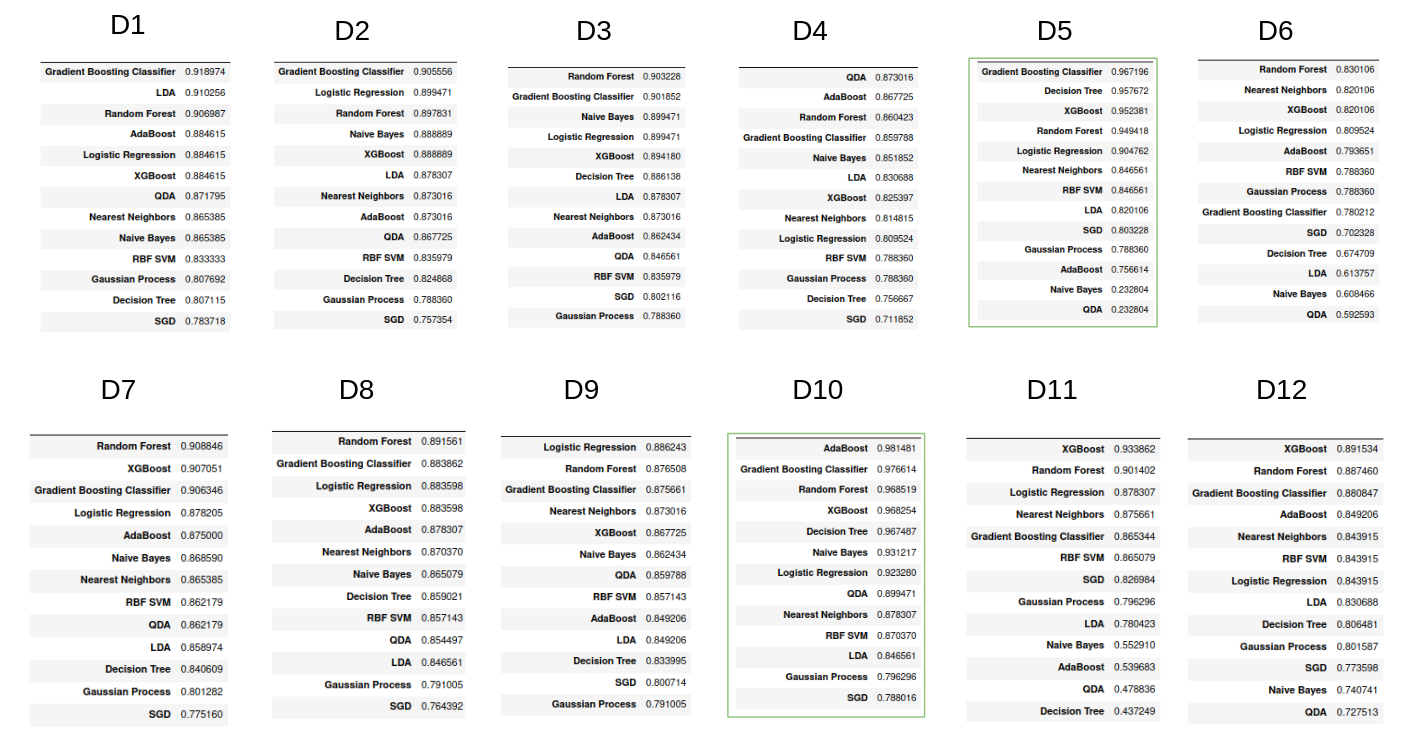

**D5** (mean imputation of raw data) and **D10** (median imputation of raw data) were most accurate based on 100 iterations of 13 different algorithms - 96.7% and 98.1% were the highest accuracies respectively. Due to the accuracy of the median imputation being slightly higher, the work was continued with this dataset. 

In [24]:
# MM
train_df = pd.read_csv("merged_data/train_median_impute.csv")
test_df = pd.read_csv("merged_data/test_median_impute.csv")

In [25]:
y_train = train_df['compliance']
X_train = train_df.drop(columns = ['compliance'])

# Test data
y_test = test_df['compliance']
X_test = test_df.drop(columns = ['compliance'])

print(f'X_train dims: {X_train.shape}')
print(f'y_train dims: {y_train.shape}')

#print(f'X_val dims: {X_val.shape}')
#print(f'y_val dims: {y_val.shape}')

print(f'X_test dims: {X_test.shape}')
print(f'y_test dims: {y_test.shape}')

X_train dims: (880, 28)
y_train dims: (880,)
X_test dims: (378, 28)
y_test dims: (378,)


## Baseline Model Selection   <a class="anchor" id="baseline_model"></a>

In the following section we are selecting and testing the baseline accuracy of 13 classifiers. Insipiration for the classifier selection can be found from [here](https://www.educative.io/blog/scikit-learn-cheat-sheet-classification-regression-methods) and [here](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html).

### An overview of classifiers   <a class="anchor" id="classifiers"></a>

Here we are testing 13 different classification algorithms. Algorithms were chosen so that they would  be different and work on a classification task. Altogether we have chosen algorithms from the following sklearn classes:

**Ensemble** algorithms that combine several base models in order to produce the most optimal model. We have 3 boosting and 1 bagging algorithm. **Boosting Models** speciality is that they are trying to improve the prediction power by training a sequence of weak models while each new model is trying to correct the errors made by the previous ones ([source](https://towardsdatascience.com/boosting-algorithms-explained-d38f56ef3f30)). **Bagging models** speciality is that they are training a bunch of individual models in a parallel way, so that each model is trained by a random subset of the data ([source](https://towardsdatascience.com/basic-ensemble-learning-random-forest-adaboost-gradient-boosting-step-by-step-explained-95d49d1e2725)).
- [AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) assigns weights to miss-classified datapoints, so that the next classifier would pay extra attention to these poins and therefore, get them right.
- [XGBoost](https://xgboost.readthedocs.io/en/stable/python/python_api.html) uses decision trees as its weak predictors
- [Gradient Boosting Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html?highlight=adaboostclassifer) focuses on the difference between the prediction and the ground truth. 
- [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) uses bagging as the ensemble method and decision tree as the individual model.

**Discriminant Analysis** is used to assign objects to one group among a number of known groups. 
- [LDA](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) is a linear model for classification and works by calculating summary statistics for the input features by class label, such as the mean and standard deviation. These statistics represent the model learned from the training data.
- [QDA](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html)  is particularly useful if there is prior knowledge that individual classes exhibit distinct covariances.

**Linear models** are a set of methods intended for regression in which the target value is expected to be a linear combination of the features.
- [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) is a linear model for classification. 
- [SGD](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) is a linear classifier optimized by SGD which implements various regularised linear models by modifying the parameter “loss”.

**Naive Bayes**. These methods are a set of supervised learning algorithms based on applying Bayes’ theorem that has an assumption of independence among predictors.
- [Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) is a probabilistic classification algorithm based on applying Bayes' theorem with strong independence assumptions.

**Gaussian Process** allows to shape your prior belief via the choice of kernel. Also, the greatest practical advantage is that they can give a reliable estimate of their own uncertainty.
- [Gaussian Process](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html) is a non-parametric algorithm that can be applied to binary classification tasks. 

**Neighbours** module implements the k-nearest neighbors algorithm.
- [Nearest Neighbours](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) assumes that similar things exist in close proximity, meanind that similar things are near to each other.

**Tree** module includes decision tree-based models for classification and regression.
- [Decision Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) can be used to visually and explicitly represent decisions and decision making. 

**SVM** is a linear model for classification (and regression) problems. It can solve linear and non-linear problems and work well for many practical problems. The idea of SVM is based on a line or a hyperplane which separates the data into classes.
- [RBF SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svc#sklearn.svm.SVC) is an SVM that uses RBF kernel that is one a widely used kernel due to its similarity to the Gaussian distribution. The RBF kernel function for two points computes the similarity or how close they are to each other.

### Classifiers and Search Spaces  <a class="anchor" id="search_space"></a>
Below we are assemblying a dataframe of classifiers (their names and operatinalizations) as well as manually defined search spaces to be used later in the hyperparameter optimization (HPO) task. We decided to add the HPO search spaces already here to provide a consistent code that allows for smoother readability and automation of tasks.

In [26]:
# Labels of classifiers
names = [
    "K-Nearest Neighbors",
    "SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
    "LDA",
    "Logistic Regression",
    "XGBoost",
    "SGD",
    "Gradient Boosting Classifier"
]

# Default/baseline classifier model classes
classifiers = [
    KNeighborsClassifier(),
    SVC(), # kernel = "rbf" by default
    GaussianProcessClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    LinearDiscriminantAnalysis(),
    LogisticRegression(),
    XGBClassifier(),
    SGDClassifier(),
    GradientBoostingClassifier()
]

# Clone the default baseline models for later use
classifiers_clone = [clone(cl_from_list, safe = True) for cl_from_list in classifiers]

# Define individual search spaces manually
search_spaces = [
    
    # KNN
    {
        'n_neighbors' : hp.choice('n_neighbors', range(2, 20, 1)), # default = 5
        'weights': hp.choice('weights', ['uniform', 'distance']), # default = 'uniform'
        'algorithm': hp.choice('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']), # default = 'auto' 
        'leaf_size': hp.choice('leaf_size', range(10, 40, 1)), # default=30
        'p': hp.choice('p', [1, 2]) # default=2
    },
    
    #SVM
    {
        'C': hp.uniform('C', 0, 1), # default = 1.0
        'kernel': hp.choice('kernel', ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']), # default=’rbf’
     #   'shrinking': hp.choice('shrinking', [True, False]), # default=True
    },
    
    # Gaussian Process
    {
        'max_iter_predict': hp.choice('max_iter_predict', range(50, 200, 1)) # default=100
    },
    
    # Decision Tree
    {
        'splitter': hp.choice('splitter', ['best', 'random']), # default='best'
        'max_depth': hp.choice('max_depth',  range(1,20)), # default=None
        'min_samples_split': hp.choice('min_samples_split', range(2, 7, 1)), # default=2
        'min_samples_leaf': hp.choice('min_samples_leaf', range(2, 7, 1)), # default=2
        'max_features': hp.choice('max_features', ['sqrt', 'log2']), # default='sqrt'
        
    },
       
    # Random Forest
    {
        'n_estimators': hp.choice('n_estimators', range(50, 250, 1)), # default=100
        'max_depth': hp.choice('max_depth',  range(1,20)), # default=None
        'min_samples_split': hp.choice('min_samples_split', range(2, 7, 1)), # default=2
        'min_samples_leaf': hp.choice('min_samples_leaf', range(2, 7, 1)), # default=2
        'max_features': hp.choice('max_features', ['sqrt', 'log2']), # default='sqrt'
    },
    
    # AdaBoost
    {
        'learning_rate': hp.uniform('learning_rate', 0.001, 0.4), # default=1.0
        'n_estimators': hp.choice('n_estimators', range(50, 250, 1)), # default=100
        
    },
    
    # Naive Bayes
    {
        'var_smoothing': hp.uniform('var_smoothing',1e-10, 1e-8), # default=1e-9
    },
    
    # QDA
    {
        'reg_param': hp.uniform('reg_param', 0.0, 0.99), # default=0.0
        'tol': hp.uniform('tol', 0.0001, 0.010), # default=0.0001
    }, 
    
    # LDA
    {
        'solver': hp.choice('solver', ['lsqr', 'eigen']), # default=’svd’
        'shrinkage': hp.uniform('shrinkage', 0.01, 1), # default=None # not supported with 'svd' solver
        
    },
    
    # Logistic Regression
    { 
        'penalty': hp.choice('penalty', ['l1', 'l2', 'elasticnet', 'none']), # default=’l2’
        'l1_ratio': hp.uniform('l1_ratio', 0, 1),
        'C': hp.uniform('C', 0, 1), # default = 1.0
        'solver': hp.choice('solver', ['saga','saga'])  # # use solver = 'saga' for using different penalties (here, give a pseudo-choice)
    },
    
    # XGBoost (Note: there a lot more hyperparameters here)
    {
        'booster': hp.choice('booster', ['gbtree', 'gblinear', 'dart']), # default = 'gbtree'
        'colsample_bylevel': hp.uniform('colsample_bylevel', 0.0, 1.0), # default = 1.0
        'colsample_bytree':  hp.uniform('colsample_bytree', 0.0, 1.0), # default = 1.0
        'learning_rate': hp.uniform('learning_rate', 0.0, 1.0), # default=0.1
        'skip_drop': hp.uniform('skip_drop', 0.0, 1.0), # default=0.0
    },
    
    # SGD
    {
        'loss': hp.choice('loss', ['hinge', 'log_loss', 'log', 
                                   'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 
                                   'huber', 'epsilon_insensitive',
                                   'squared_epsilon_insensitive']), # default=’hinge’
        'penalty': hp.choice('penalty', ['l1', 'l2', 'elasticnet']), # default=’l2’
        'alpha': hp.uniform('alpha', 0, 0.01), # default=0.0001
        'learning_rate': hp.choice('learning_rate', ['constant', 'optimal', 'invscaling', 'adaptive']) # default=’optimal’
        
    },

    # GBC
    {
        'learning_rate': hp.uniform('learning_rate', 0.001, 0.4), # default=0.1
        'n_estimators': hp.choice('n_estimators', range(50, 250, 1)), # default=100
        'subsample': hp.uniform('subsample', 0.60, 1.0), # default=1.0
    #    'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2']), # default=None
     #   'min_samples_split': hp.uniform('min_samples_split', 0.0, 1.0), # default=2 # NB! decided for using float instead of int
     #  'min_samples_leaf': hp.uniform('min_samples_leaf', 0.0, 1.0), # default=1 # NB! decided for using float instead of int
     #   'min_weight_fraction_leaf': hp.uniform('min_weight_fraction_leaf', 0.0, 0.5), # default=0.0
        'max_depth': hp.choice('max_depth', range(1,20)), # default=3
    #    'warm_start': hp.choice('warm_start', [True, False])
        
    }
]

# Dataframe for model names, classes, and search spaces
df_models = pd.DataFrame({'name': names, 'classifier': classifiers, 'search_space' : search_spaces})
df_models['n_hp'] = df_models['search_space'].map(len) # the number of hyperparameters in search space

Because some of the classifiers have very varying results depending on the random state, we run them trough 100 iterations to get their average accuracy score. We use **accuracy** score to compare the baseline models.

In [27]:
# Define the number of iterations
iterations = 100

df_models2 = df_models.copy()
bl_runtimes = {}
bl_scores = {}

# Iterate over all classifiers
for i in range(len(df_models)):
    classifier_name = df_models2['name'][i]
    classifier = df_models2['classifier'][i]
    times = []
    scores = []
    # Compute the model accuracy and runtime for N iterations for each classifier
    for j in range(iterations):
        start_time = time.time() # track time
        
        # Train and test the model
        classifier.fit(X_train, y_train)
        score = classifier.score(X_test, y_test)
        
        end_time = time.time() # track time
        totalTime = end_time - start_time
        
        scores.append(score)
        times.append(totalTime)
    
    bl_runtimes[classifier_name] = times
    bl_scores[classifier_name] = scores
    
# Transforming the results to long dataframes
bl_runtimes = pd.DataFrame(bl_runtimes).transpose().reset_index()
bl_runtimes = pd.melt(bl_runtimes, id_vars='index', var_name = 'iter')
bl_runtimes.rename(columns = {'index':'name', 'value': 'runtime'}, inplace = True)

bl_scores = pd.DataFrame(bl_scores).transpose().reset_index()
bl_scores = pd.melt(bl_scores, id_vars='index', var_name = 'iter')
bl_scores.rename(columns = {'index':'name', 'value': 'accuracy'}, inplace = True)
# Merge into one table
bl_results = bl_runtimes.merge(bl_scores)

### Baseline Performance of Classifiers  <a class="anchor" id="bl_performance"></a>
Below the performance of baseline models across 100 computations are displayed. Specifically, the figures show the distributions of (a) accuracy scores as well as (b) runtimes for each classifier across 100 iterations.

### Accuracy of baseline models

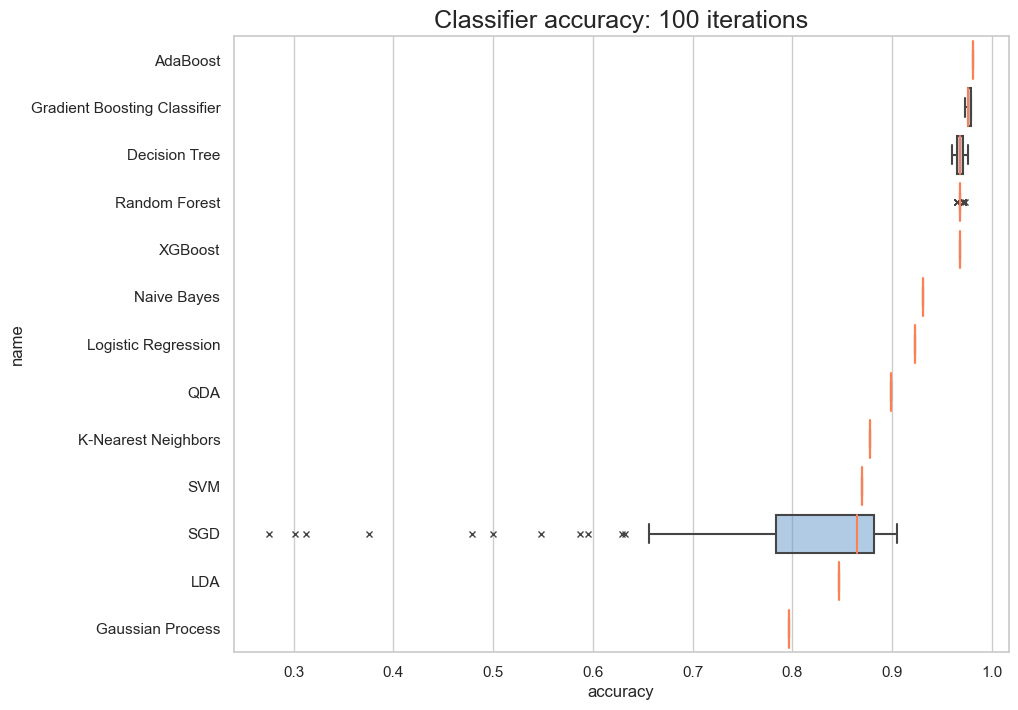

In [28]:
# Create the data
grouped_s = bl_scores.loc[:,['name', 'accuracy']] \
    .groupby(['name']) \
    .median() \
    .sort_values(by='accuracy', ascending = False)

# Set the figure properties
sns.set(rc={'figure.figsize':(10,8)})
sns.set_style("whitegrid") 

# Figure
sns.boxplot(data= bl_scores, x="accuracy", y="name", 
            order = grouped_s.index,
            flierprops={"marker": "x"},
            boxprops={"facecolor": (.4, .6, .8, .5)},
            medianprops={"color": "coral"}
           ).set_title('Classifier accuracy: 100 iterations', fontsize=18);

### Runtime of baseline models

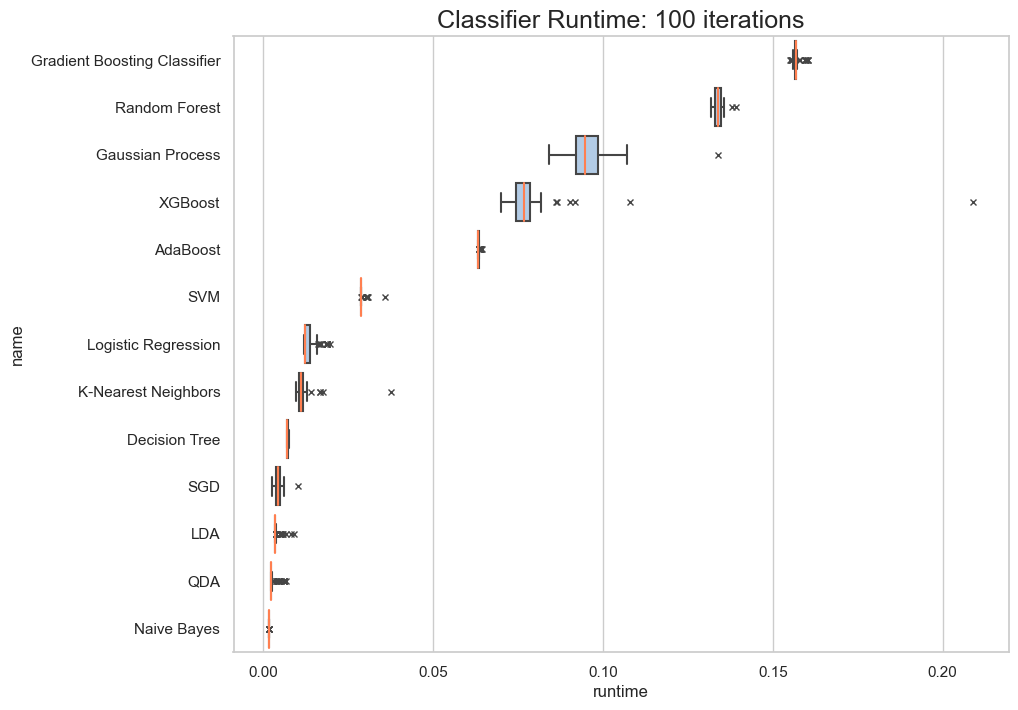

In [29]:
# Create the data
grouped_rt = bl_runtimes.loc[:,['name', 'runtime']] \
    .groupby(['name']) \
    .median() \
    .sort_values(by='runtime', ascending = False)

# Set the figure properties
sns.set(rc={'figure.figsize':(10,8)})
sns.set_style("whitegrid") 

# Figure
sns.boxplot(data= bl_runtimes, x="runtime", y="name", 
            order = grouped_rt.index,
            flierprops={"marker": "x"},
            boxprops={"facecolor": (.4, .6, .8, .5)},
            medianprops={"color": "coral"}
           ).set_title('Classifier Runtime: 100 iterations', fontsize=18);

Below we present the aggregated results (average and median) for each classifier across all iterations.

In [30]:
# Compute the median and average accuracy and runtime; sort by decreasing accuracy and increasing runtime
bl_agg = bl_results.groupby(['name']).agg({'accuracy': ['mean', 'median'], 'runtime': ['mean', 'median']})
bl_agg.columns = ['_'.join(col) for col in bl_agg.columns]
bl_agg = bl_agg[['accuracy_mean', 'runtime_mean']].sort_values(['accuracy_mean', 'runtime_mean'], ascending = [0,1]).reset_index()
bl_agg = bl_agg.rename(columns = {'accuracy_mean': 'bl_acc', 'runtime_mean': 'bl_runtime'})
bl_agg

,name,bl_acc,bl_runtime
0,AdaBoost,0.981481,0.063330
1,Gradient Boosting Classifier,0.976693,0.156836
2,Random Forest,0.968413,0.133919
3,XGBoost,0.968254,0.078324
4,Decision Tree,0.968228,0.006926
5,Naive Bayes,0.931217,0.001558
6,Logistic Regression,0.923280,0.013380
7,QDA,0.899471,0.002585
8,K-Nearest Neighbors,0.878307,0.011448
9,SVM,0.870370,0.028883


When looking only accuracies, it seems that the best performing classifier is [AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html).  **But what about runtime?**  
Next, we are going to rank classifers based on how they ranked in accuracy and runtime leaderboards. The higher the accuracy, the higher the rank. The lower the runtime, the higher the rank.

In [31]:
runtime_df = bl_agg.copy()
runtime_df = runtime_df.sort_values(by=['bl_runtime'], ascending=True, ignore_index=True)
runtime_df['runtime_rank'] = range(1, len(runtime_df) + 1)
runtime_df = runtime_df.drop(['bl_acc'], axis=1)

accuracy_df = bl_agg.copy()
accuracy_df = accuracy_df.sort_values(by=['bl_acc'], ascending=False, ignore_index=True)
accuracy_df['accuracy_rank'] = range(1, len(accuracy_df) + 1)
accuracy_df = accuracy_df.drop(['bl_runtime'], axis=1)

df_merged = pd.merge(runtime_df, accuracy_df, how='inner', on = 'name')
df_merged['rank_sum'] = df_merged.apply(lambda row: row.runtime_rank + row.accuracy_rank, axis=1)
df_merged['rank_sum'] = df_merged['rank_sum'].astype('int')
df_merged = df_merged.sort_values(by=['rank_sum'])
df_merged = df_merged.reset_index(level=0)
df_merged = df_merged.drop(['index'], axis=1)
df_merged

,name,bl_runtime,runtime_rank,bl_acc,accuracy_rank,rank_sum
0,Naive Bayes,0.001558,1,0.931217,6,7
1,QDA,0.002585,2,0.899471,8,10
2,Decision Tree,0.006926,5,0.968228,5,10
3,AdaBoost,0.063330,9,0.981481,1,10
4,LDA,0.003774,3,0.846561,11,14
5,Logistic Regression,0.013380,7,0.923280,7,14
6,XGBoost,0.078324,10,0.968254,4,14
7,K-Nearest Neighbors,0.011448,6,0.878307,9,15
8,Random Forest,0.133919,12,0.968413,3,15
9,Gradient Boosting Classifier,0.156836,13,0.976693,2,15


The top 5 classifers based on accuracy **and** runtime are Naive Bayes, Decision Tree, AdaBoost, QDA and Gradient Boosting Classifier. So, the table above shows that when considering both, the top5 classifers have changed. 
When comparing the total rank table to the previous table with accuracy top 5, we notice that AdaBoost is no longer first and is instead third. The first place goes to Naive Bayes and second place to Decision Tree. As we notice, the first place classifier Naive Bayes has 5% lower accuracy, but is (0.187773/0.006927) 27x faster. Similarly, the second place classifier Decision Tree is only 1.3% lower accuracy, but runtime is a about 10x (0.187773/0.018597) faster.

While this is a great and quite an easy way to see the runtime vs accuracy tradeoff, in our case the evaluation metric for this Kaggle competition is only **accuracy**. 
Additionally, due to the nature of our dataset, i.e it being quite lightweight and not having much rows, we can afford for the model to train longer until it outputs a better accuracy and therefore, we can afford to run "slower" models. If we had a significantly larger dataset (or the data would be constantly added, e.g. from the stations monitoring the water quality indicators), then this accuracy-runtime tradeoff would have to be taken into account.

<font color = 'red'> SIIA KIRJUTADA JÄRELDUSED: MIS OLID TOP ALGORITMID </font>

Let us now zoom in on the five best classifiers and choose them for hyperparameter optimization.

In [32]:
# Add the best average accuracies and runtimes to the `df_models` dataframe defined earlier
df_models = df_models2.merge(bl_agg).sort_values(['bl_acc', 'bl_runtime'], 
                                                ascending = [0,1]).reset_index(drop = True)


# Choose the top 5 baseline classifiers
top_k = 5 # can be changed if needed
df_best_bl = df_models.iloc[:top_k] # choose only the top algos' aggregated results
df_best_bl[['name', 'bl_acc', 'bl_runtime']]

,name,bl_acc,bl_runtime
0,AdaBoost,0.981481,0.063330
1,Gradient Boosting Classifier,0.976693,0.156836
2,Random Forest,0.968413,0.133919
3,XGBoost,0.968254,0.078324
4,Decision Tree,0.968228,0.006926


## Hyperparameter optimization (HPO)   <a class="anchor" id="hpo"></a>
In the rpesetn project, we are using the `hyperopt` library to perform HPO for which a great tutorial can be found [here](https://medium.com/district-data-labs/parameter-tuning-with-hyperopt-faa86acdfdce). The `hyperopt` Python module implements Bayesion Hyperparameter Optimization (HPO), and within this module, one needs to define manually the search space for a given model/classifier.

With the following codeblock, we are implementing the HPO by iterating over the selected classifiers and their manually-defined search spaces. The best classifiers as well as their potential search space is saved in the previous section into the `df_best_bl` dataframe.

In [33]:
# Initialize a dataframe for results collection
hpo_results = pd.DataFrame(columns = ['classifier_name', 'best_cv_score', 'runtime_hpo', 'best_params', 'test_acc'])

# Define the best baseline score
best_baseline_score = df_best_bl.loc[0, 'bl_acc']

# Define how many iterations should be done
n_trials = 100

# All individual trials will be saved here
trials_dict = {}

# Start the timer to measure the runtime of the entire pipeline
hpo_time_start = time.time()

# Run the HPO and get the best params for each classifier
for i in range(len(df_best_bl)):
    
    # To improve the raedability of code, creating the following objects:
    classifier_name = df_best_bl.loc[i, 'name']
    classifier_class = classifiers[names.index(classifier_name)] # fetch from the list not df for baseline
    classifier_search_space = df_best_bl.loc[i, 'search_space']
    
    # To improve the readability of output:
    print()
    print('----------------------------------------------------------------------')
    print(f'Using *{classifier_name}* for estimation.')
    print('----------------------------------------------------------------------')
    
    # A helper function for receiving the CV scores for each model
    def hyperopt_cv_score(params):
        cv = RepeatedKFold(n_splits=5, n_repeats=5) # can be also adjusted!
        model = classifier_class.set_params(**params) # use the classifier from the list
        return cross_val_score(model, 
                               X_train, y_train, 
                               cv = cv,  
                               scoring = 'accuracy',
                               error_score='raise').mean() 

    # A helper function for finding the best model
    def f(params):
        global best_cv_score
        global best_params
        global best_time
        
        cv_score = hyperopt_cv_score(params)
    
        if cv_score > best_cv_score:
            # Are we bearing the best baseline score?
            if cv_score > best_baseline_score: # we are beating the baseline accuracy
                best_cv_score = cv_score # what is the best score?
                best_params = params # what are the best params?
                best_time = round(time.time() - start_time,4) # track how much time it took to find the best params
                
                print(f'*{classifier_name}* BEAT THE BASELINE of {best_baseline_score}!')
                print(f'Better CV score: {best_cv_score}')
                print(f'Parameter combination: {best_params}')
                print(f'Time until beating the baseline: {best_time}s')
            else: 
                best_cv_score = cv_score # what is the best score?
                best_params = params # what are the best params?
                best_time = round(time.time() - start_time,4) # track how much time it took to find the best params

                # Print the results for reference
                print(f'New best CV score: {best_cv_score}')
                print(f'New best params: {best_params}')
                print(f'Time taken until new best combination found: {round(best_time, 5)}s')

        return {'loss': -cv_score, # see the comment below
                'status': STATUS_OK}
        # Comment regarding 'negative cv_score' (from the referenced source):
        ## Since we are trying to maximize the CV score (cv_score in the code above), 
        ## we must negate this value for hyperopt, since hyperopt only knows how to minimize a function. 
        ## Minimizing a function f is the same as maximizing the negative of f.
        ## About FMIN: https://github.com/hyperopt/hyperopt/wiki/FMin
        
    # Defining global variables to be updated
    best_cv_score = 0 # best CV score
    best_params = None # best hyperparameter combination
    best_time = 0 # runtime until the best CV score is computed
    trials = Trials() # store info at each step
    
    # Start running the algorithm and track time
    start_time = time.time()
    ## Objective function
    best = fmin(f, 
                classifier_search_space, # use the search space associated with the classifier
                algo = tpe.suggest, 
                max_evals = n_trials, # how many evaluations?
                trials = trials)
    # Save all trials
    trials_dict[classifier_name] = trials # save into classifier-trials 
    
    print()
    print('######################################################################')
    # Print the summary of the best results
    print(f'Best CV score in {n_trials} iterations: {best_cv_score} ({best_time}s until found).')
    
    # Compute the accuracy score on the best model of the classifier
    m = classifier_class.set_params(**best_params).fit(X_train, y_train)
    score_test = m.score(X_test, y_test)
    print(f'Accuracy score on test data: {score_test}.')
    
    
    # Append the best results to the df
    hpo_results = hpo_results.append({'classifier_name': classifier_name, 
                             'best_cv_score': best_cv_score, 
                             'runtime_hpo': best_time, 
                             'best_params': best_params,
                             'test_acc': score_test}, ignore_index = True)

# Mark the end of the entire pipeline
hpo_time_end = time.time()
print()
print('######################################################################')
print(f'The duration of the entire HPO pipeline for {len(df_best_bl)} classifiers across {n_trials} trials each: ')
print(f'{round(hpo_time_end - hpo_time_start, 5)} seconds')

# Sort the model results by test accuracy score and then Runtime
hpo_results = hpo_results.sort_values(['test_acc', 'runtime_hpo'], ascending = [0,1]).reset_index(drop = True)


----------------------------------------------------------------------
Using *AdaBoost* for estimation.
----------------------------------------------------------------------
New best CV score: 0.9806818181818181                                           
New best params: {'learning_rate': 0.32529955562428, 'n_estimators': 229}       
Time taken until new best combination found: 6.4222s                            
*AdaBoost* BEAT THE BASELINE of 0.9814814814814815!                             
Better CV score: 0.9836363636363636                                             
Parameter combination: {'learning_rate': 0.23685846312906694, 'n_estimators': 209}
Time until beating the baseline: 17.8226s                                       
*AdaBoost* BEAT THE BASELINE of 0.9814814814814815!                             
Better CV score: 0.9845454545454545                                             
Parameter combination: {'learning_rate': 0.2898889790748058, 'n_estimators': 166}
Time until 

[10:02:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:02:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:02:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:02:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:02:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpyt

[10:02:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:02:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:02:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:02:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:02:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:02:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.maco

[10:02:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:02:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:02:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:02:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:02:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpyt

[10:02:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:02:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:02:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:02:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:02:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:02:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.maco

[10:02:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:02:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:02:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:02:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:02:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:02:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.maco

[10:02:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:02:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:02:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:02:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:02:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:02:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.maco

[10:02:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:02:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:02:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:02:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:02:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:02:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.maco

[10:02:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:02:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:02:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:02:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:02:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpyt

[10:02:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:02:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:02:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:02:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:02:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "m

[10:03:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:03:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:03:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:03:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:03:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:03:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.maco

[10:05:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:05:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:05:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:05:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:05:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpyt

[10:06:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_threshold", "max_cat_to_onehot", "max_delta_step", "max_depth", "max_leaves", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "sampling_method", "skip_drop", "subsample", "tree_method" } are not used.

[10:06:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:06:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:06:11] WARNING: /Users/runner/

[10:06:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:06:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:06:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:06:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:06:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpyt

[10:07:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:07:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:07:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:07:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_threshold", "max_cat_to_onehot", "max_delta_step", "max_depth", "max_leaves", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "sampling

[10:07:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:07:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:07:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:07:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:07:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:07:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.maco

[10:07:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:07:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:07:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:07:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:07:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpyt

[10:07:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:07:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:08:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:08:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:08:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:08:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.maco

[10:08:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:08:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:08:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:08:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:08:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:08:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.maco

[10:09:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:09:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:09:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:09:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:09:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpyt

[10:12:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:12:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:12:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:12:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:12:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpyt

[10:12:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:12:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:12:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:12:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:12:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:12:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.maco

[10:13:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:13:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:13:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:13:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:13:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:13:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.maco

[10:13:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:13:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:13:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:13:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:13:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpyt

[10:14:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:14:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:14:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:14:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "skip_drop" } are not used.

[10:14:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpyt

[10:14:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:14:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:14:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:14:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:14:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "skip_drop" } are not used.

[10:14:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.maco

100%|██████| 100/100 [13:03<00:00,  7.84s/trial, best loss: -0.9729545454545455]

######################################################################
Best CV score in 100 iterations: 0.9729545454545455 (98.4315s until found).
Accuracy score on test data: 0.9682539682539683.

----------------------------------------------------------------------
Using *Decision Tree* for estimation.
----------------------------------------------------------------------
New best CV score: 0.8281818181818181                                           
New best params: {'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 5, 'splitter': 'random'}
Time taken until new best combination found: 0.0572s                            
New best CV score: 0.9118181818181817                                           
New best params: {'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'splitter': 'best'}
Time taken until new best combination found: 

In [34]:
# Add a clumn which says if the classifier beat the baseline
hpo_results['beats_bl'] = np.where(hpo_results.loc[:,'test_acc'] > best_baseline_score, 'yes', 'no')

# See the HPO results
hpo_results

,classifier_name,best_cv_score,runtime_hpo,best_params,test_acc,beats_bl
0,AdaBoost,0.984545,62.8980,"{'learning_rate': 0.2898889790748058, 'n_estim...",0.981481,no
1,Gradient Boosting Classifier,0.984091,217.6648,"{'learning_rate': 0.16609252215233983, 'max_de...",0.978836,no
2,XGBoost,0.972955,98.4315,"{'booster': 'dart', 'colsample_bylevel': 0.741...",0.968254,no
3,Random Forest,0.970000,264.7467,"{'max_depth': 17, 'max_features': 'sqrt', 'min...",0.968254,no
4,Decision Tree,0.941136,3.4135,"{'max_depth': 15, 'max_features': 'sqrt', 'min...",0.912698,no


All of these models have generally fared off pretty well. Out of these solutions, are ther eany models that beat the baseline? If yes, which model(s) exactly? If no models beat the baseline, the result is an empty data frame.

In [35]:
bl_beaters = hpo_results[(hpo_results['beats_bl'] == 'yes')]
bl_beaters[bl_beaters['runtime_hpo'] == bl_beaters['runtime_hpo'].min()]

,classifier_name,best_cv_score,runtime_hpo,best_params,test_acc,beats_bl


### Accuracy-Runtime Comparison for Classifiers  <a class="anchor" id="hpo_acc_runtime"></a>
Let's plot the model test set accuracy against runtime.

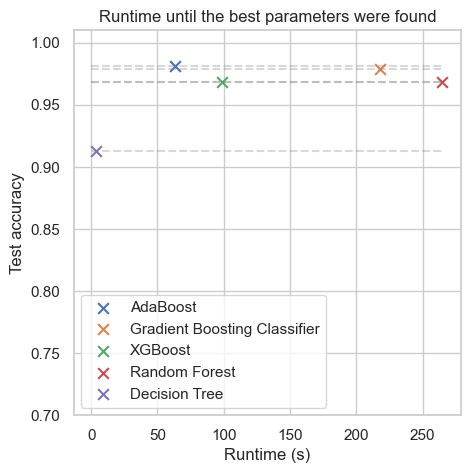

In [36]:
plt.figure(figsize = [5, 5])

for i in range(len(hpo_results)):
    # Add classifier values
    plt.scatter(hpo_results['runtime_hpo'][i], 
            hpo_results['test_acc'][i], 
            label = hpo_results['classifier_name'][i],
               marker = 'x',
               s = 60)
    plt.legend()
    # Add a dashed lined marking the best accuracy threshold for classifier
    plt.hlines(y = hpo_results['test_acc'][i], 
               xmin=0, 
               xmax = np.max(hpo_results['runtime_hpo'])+1,
              linestyles = 'dashed', alpha = 0.3, color = 'grey')
    # Add classifier name
#    plt.annotate(hpo_results['classifier_name'][i], 
#                 (hpo_results['runtime_hpo'][i]+1, 
#                  hpo_results['test_acc'][i]),
#                )
plt.ylim(bottom = 0.70, top = 1.01)
plt.xlabel('Runtime (s)')
plt.ylabel('Test accuracy')
plt.title('Runtime until the best parameters were found')
plt.show();

### Hyperparameter-Accuracy Links Across All Trials  <a class="anchor" id="hpo_params_trials"></a>

In addition to displaying the best accuracies and runtimes of each classifier, let's also look into how the accuracy scores were associated with different values of hyperparameters. For that, we first define a helper function that take classifier and its trials' related information as input and provides the parameter value-accuracy figure as output. We then iterate over all models to display the values of parameters in relation to accuracy scores accross all trials.

In [37]:
def params_plot(classifier_name, trials, parameters):
    """Parameters plot from trials
    Args:
        classifier_name (str): the name of the classifier
        trials (trials obj): all trials from runs
        parameters (list): list of parameters to be plotted
    
    Returns: 
        plot for parameter performance across trials
    """
    # Define the figure (make a 2x3 grid universally)
    f, axes = plt.subplots(nrows=2, ncols=3, figsize=(8,5))
    f.suptitle(f'{classifier_name} HP performance across {len(trials)} trials') # set the plot title
    f.tight_layout()

    cmap = plt.cm.jet
    for i, val in enumerate(parameters):
        # Getting the hyperparameter and loss values with list comprehension
        xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
        ys = [-t['result']['loss'] for t in trials.trials]
        # Making the necessary sorting
        xs, ys =  zip(*sorted(zip(xs, ys)))
        ys = np.array(ys)

        # Plot
        axes[int(i/3),int(i%3)].scatter(xs, ys, 
                              s=10, 
                              linewidth=0.01, 
                             # alpha= 0.5,
                              color=cmap(float(i)/len(parameters))
                                       )
        axes[int(i/3),int(i%3)].set_title(val)
        axes[int(i/3),int(i%3)].set_ylim([0.2,1.0])

    plt.show();

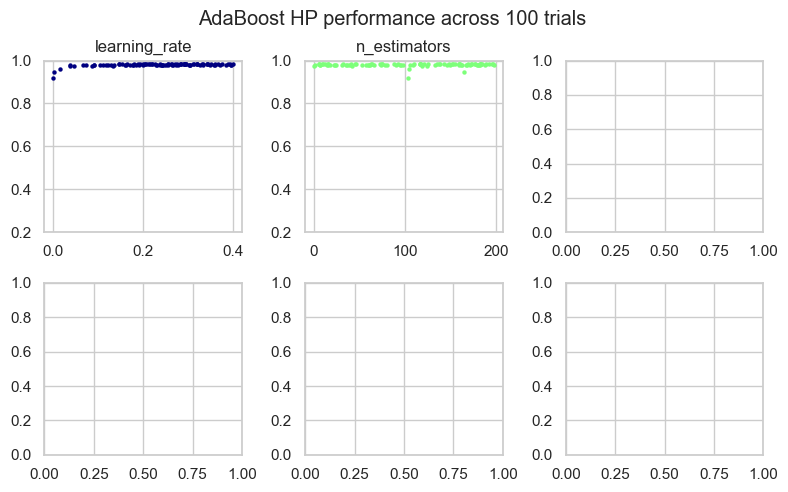

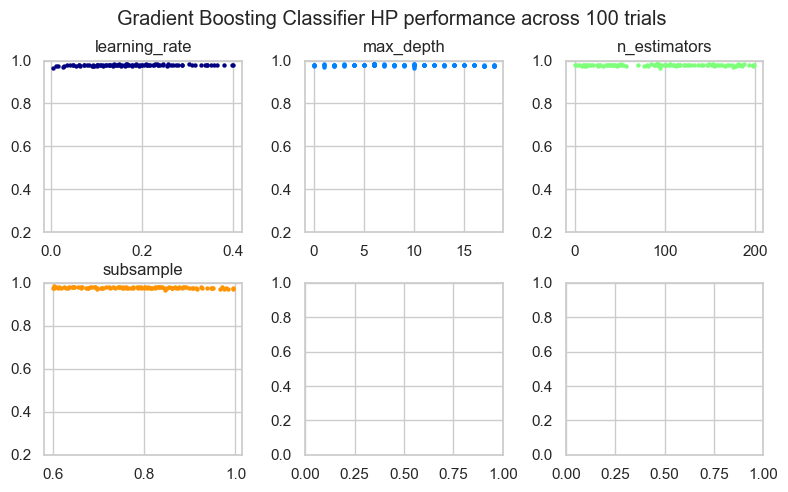

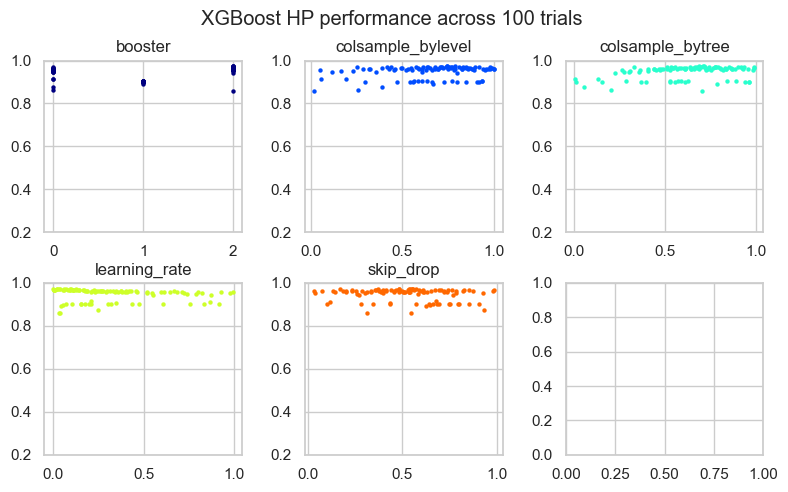

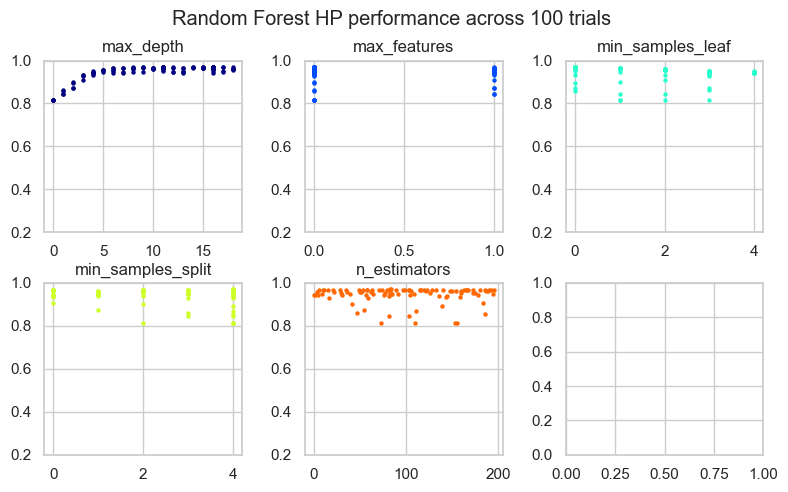

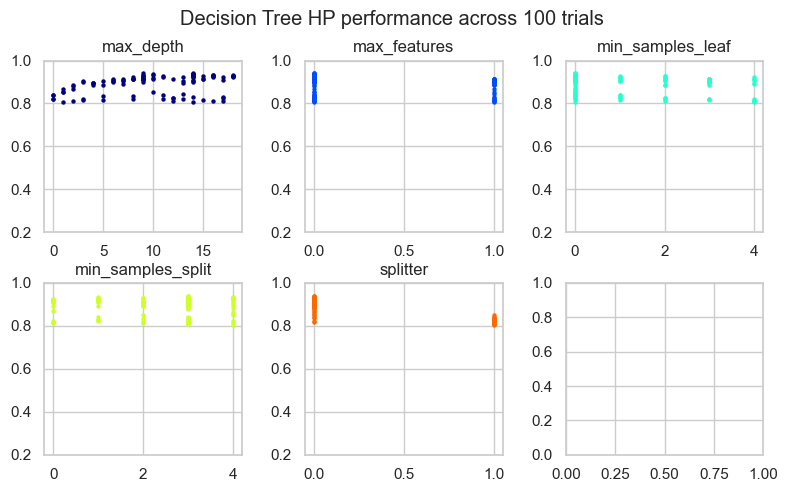

In [38]:
for i in range(len(hpo_results)):
    classifier_name = hpo_results.loc[i, 'classifier_name']
    trials = trials_dict[classifier_name] # siin vb bug - peab korraks veel a la QDA puhul vaatama
    parameters = hpo_results.loc[i, 'best_params'].keys()
    # figure
    params_plot(classifier_name, trials, parameters)

# Significance testing <a class="anchor" id="sig_testing"></a>
In the below section, we will test whether the differences between the models are statistically significant. Although the specific focus is on testing the best baseline vs the best HPO-d model, we provide additional comparisons with other models, too.

The process is as follows: for each classifier (be it the baseline or HPO-engineered), we use repeated k-folds to create, in total, 100 scores for each model (5 splits, 20 repeats = 100 samples). Then, the scores are compared with the Friedman's chi-squared test. However, because the test only tells if there *is* (or is not) a statistically signifcant difference without specifying *between which pairs* is there (or is not) a difference, we use the Nemenyi's post-hoc tesitng to pinpoint the pairwise differences. 

As mentioned, **the main goal here is to see if the best baseline model is statistically signifcantly differnt than the best model with optimized hyperparameter values**. 

In [39]:
# Best baselines
# Best models
sig_test_classifiers = [] # insantiate classifier name list
cv_scores_bl = {} # instantiate a dictionary for CV scores collection for baselines
cv_scores_hpo = {} # instantiate a dictionary for CV scores collection for best HPO models

for i in range(len(hpo_results)):
    # Remove spaces from classifier name
    classifier_name_hpo = hpo_results.loc[i, 'classifier_name'].replace(' ', '')
    classifier_name_bl = hpo_results.loc[i, 'classifier_name'].replace(' ', '') + '_bl'
    
    best_params_hpo = hpo_results['best_params'][i]
    
    # Define and instantiate the splits
    folds5 = RepeatedKFold(n_splits = 5, n_repeats = 20, random_state = 2022) 
    
    # Fit the baseline and HPO
    model_bl = classifiers_clone[names.index(hpo_results.loc[i, 'classifier_name'])].fit(X_train, y_train)
    model_hpo = classifiers[names.index(hpo_results.loc[i, 'classifier_name'])].set_params(**best_params_hpo).fit(X_train, y_train)
    
    # Get the model scores for basleine and HPO
    scores_bl = cross_val_score(model_bl, X_test, y_test, scoring = "accuracy", cv = folds5)
    scores_hpo = cross_val_score(model_hpo, X_test, y_test, scoring = "accuracy", cv = folds5)
    
    # Save cv scores and the classifier name
    cv_scores_bl[classifier_name_bl] = scores_bl
    cv_scores_hpo[classifier_name_hpo] = scores_hpo
    
    # Save the classfiers' names
    sig_test_classifiers.append(classifier_name_bl)
    sig_test_classifiers.append(classifier_name_hpo)

# Create a dataframe
cv_scores_bl = pd.DataFrame(cv_scores_bl)
cv_scores_hpo = pd.DataFrame(cv_scores_hpo)
cv_scores = pd.concat([cv_scores_bl, cv_scores_hpo], axis = 1)
cv_scores.head()

,AdaBoost_bl,GradientBoostingClassifier_bl,XGBoost_bl,RandomForest_bl,DecisionTree_bl,AdaBoost,GradientBoostingClassifier,XGBoost,RandomForest,DecisionTree
0,0.881579,0.960526,0.802632,0.855263,0.907895,0.855263,0.934211,0.868421,0.881579,0.644737
1,0.960526,0.960526,0.934211,0.960526,0.947368,0.960526,0.960526,0.934211,0.934211,0.907895
2,0.960526,0.973684,0.934211,0.934211,0.973684,0.973684,0.921053,0.934211,0.934211,0.868421
3,0.933333,0.933333,0.946667,0.933333,0.920000,0.933333,0.946667,0.946667,0.960000,0.920000
4,0.973333,0.973333,0.946667,0.973333,0.973333,0.973333,0.973333,0.960000,0.960000,0.866667


Let's remind us what were the best baseline and the best HPO-engineered models:

In [40]:
best_name_bl = df_best_bl['name'][0]
best_test_bl = df_best_bl['bl_acc'][0]

best_name_hpo = hpo_results['classifier_name'][0]
best_test_hpo = hpo_results['test_acc'][0]
best_params_hpo = hpo_results['best_params'][0]

print(f'The classifier with the best baseline accuracy: {best_name_bl} (test accuracy: {round(best_test_bl,5)}).')
print(f'The classifier with the best accuracy after HPO: {best_name_hpo} (test accuracy: {round(best_test_hpo,5)}).')
print(f'The hyperparameters of the best model with HPO:\n{best_params_hpo}')

The classifier with the best baseline accuracy: AdaBoost (test accuracy: 0.98148).
The classifier with the best accuracy after HPO: AdaBoost (test accuracy: 0.98148).
The hyperparameters of the best model with HPO:
{'learning_rate': 0.2898889790748058, 'n_estimators': 166}


In order to compare whether the the models produce statistically significantly different predictions (opeartionalized as accuracy scores), we use dependent-samples t-test. The reason to not use independent samples t-test is because the predictions (and, hende, accuracy scores) are generated by using the same data splits for both models.

In [41]:
# Get the arrays with scores
baseline_cvscores = cv_scores[best_name_bl.replace(' ', '')+ '_bl']
hpo_cvscores = cv_scores[beshttp://localhost:8888/notebooks/xAutoML-Project1/project1_notebook.ipynb#Model-Accuracy-Validation-via-a-Kaggle-Competition-t_name_bl.replace(' ', '')]

# Dependent-samples t-test
tstat, p = ttest_rel(baseline_cvscores,
                     hpo_cvscores, 
                     axis = 0)

if p < 0.05: 
    print(f'The results of dependent-samples t-test show that the baseline '
          f'and HPO-engineered models differ statistically significantly, '
          f't = {round(tstat,4)}, p = {round(p ,4)}.')
    
    if best_test_bl > best_test_hpo:
        print(f'The baseline performed better (test accuracy = {best_test_bl}) than '
        f'the HPO-engineered model (test accuracy = {best_test_hpo}).')
    else:
        print(f'The HPO-engineered model performed better (test accuracy = {best_test_hpo}) than '
        f'the baseline model (test accuracy = {best_test_bl}).')
    
else:
    print(f'The results of dependent-samples t-test show '
    f'that the baseline and HPO-engineered models do not '
    f'differ statistically significantly, t = {round(tstat,4)}, p = {round(p ,4)}.')

The results of dependent-samples t-test show that the baseline and HPO-engineered models do not differ statistically significantly, t = -1.5155, p = 0.1328.


<font color = 'red'> DISCUSSION OF THE RESULTS </font>

<font color = 'red'> SIIA MINGID COMMENTID </font>

## Model Accuracy Validation via a Kaggle Competition <a class="anchor" id="kaggle"></a>
Although the provide the optimism for great accuracy, it would be a great idea to test the performance of the models with a hold-out data set. To that end, because our project uses a Kaggle competition data set, we can test the goodness of our models with a hold out data set on Kaggle. Below, the code cell fits the best baseline and HPO-engineered models and submits them to kaggle.

A note on Kaggle: In case you receive status 401 - Unauthorized: 
1. Go to Kaggle, expire previous Tokens
2. Create New API Token
3. Change it to the new file in root/.kaggle directory

#### Best baseline model

In [48]:
# List of station_id-s
df_submission = pd.read_csv('data/sample_submission.csv')
station_ids_kaggle = df_submission['station_id'].values

# 1. Create predictions for best baseline
best_baseline = classifiers_clone[names.index(df_models['name'][0])]
best_bl_fit = best_baseline.fit(X_train, y_train)
preds_bl = best_bl_fit.predict(X_test)

# 2. Create a Kaggle dataframe, save to .csv
df_bl = pd.DataFrame({'station_id':X_test['station_id'], 'compliance_2021':preds_bl}) 
df_bl = df_bl[df_bl['station_id'].isin(station_ids_kaggle)]
df_bl1 = df_bl[:len(df_submission)]
df_bl2 = df_bl[len(df_submission):]
df_bl1.to_csv('df_bl1.csv', index=False)
df_bl2.to_csv('df_bl2.csv', index=False)

# 3. Submit the Kaggle .csv
!kaggle competitions submit -c drinking-water-quality -f df_bl1.csv -m 'Best Baseline (2020) submission'
!kaggle competitions submit -c drinking-water-quality -f df_bl2.csv -m 'Best Baseline (2019) submission'

100%|████████████████████████████████████████| 1.20k/1.20k [00:01<00:00, 732B/s]
100%|████████████████████████████████████████| 1.20k/1.20k [00:02<00:00, 561B/s]
Successfully submitted to Drinking Water Quality Prediction

#### Best HPO-engineered model

In [49]:
# 1. Create predictions for best baseline
best_hpo = classifiers_clone[names.index(hpo_results['classifier_name'][0])]
best_hpo_fit = best_hpo.set_params(**hpo_results['best_params'][0]).fit(X_train, y_train)
preds_hpo = best_hpo_fit.predict(X_test)

# 2. Create a Kaggle dataframe, save to .csv
df_hpo = pd.DataFrame({'station_id':X_test['station_id'], 'compliance_2021':preds_hpo}) 
df_hpo = df_hpo[df_hpo['station_id'].isin(station_ids_kaggle)]
df_hpo1 = df_hpo[:len(df_submission)]
df_hpo2 = df_hpo[len(df_submission):]
df_hpo1.to_csv('df_hpo1.csv', index=False)
df_hpo2.to_csv('df_hpo2.csv', index=False)

# 3. Submit the Kaggle .csv
!kaggle competitions submit -c drinking-water-quality -f df_hpo1.csv -m 'Best HPO (2019) submission'
!kaggle competitions submit -c drinking-water-quality -f df_hpo2.csv -m 'Best HPO (2020) submission'

100%|████████████████████████████████████████| 1.20k/1.20k [00:02<00:00, 522B/s]
100%|████████████████████████████████████████| 1.20k/1.20k [00:01<00:00, 726B/s]
Successfully submitted to Drinking Water Quality Prediction

#### Kaggle results
After running the analyses and submitting the predictions to kaggle, below are the results.

![](kaggle_results.png)

## Summary and Conclusions <a class="anchor" id="summary"></a>
<font color = 'red'> kirjutada </font>